<a href="https://colab.research.google.com/github/Archi2903/AI-in-Engenery/blob/main/Project_LSTM_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Denoising TEM Data with LSTM Autoencoder

In [1]:
# Synthetic TEM Data Generation

import numpy as np

# Example: generate one synthetic clean TEM decay signal (normalized)
def generate_clean_signal(n_points=50):
    t = np.logspace(-5, -2, n_points)  # time (s)
    y = np.zeros_like(t)
    # Sum of a few decaying exponentials
    for A, tau in zip(np.random.uniform(0.5,1.5,3), np.random.uniform(0.01,0.1,3)):
        y += A * np.exp(-t/tau)
    y = y / np.max(y)  # normalize amplitude
    return t, y

# Generate dataset
n_samples = 200
times = []
clean_signals = []
for i in range(n_samples):
    t, y = generate_clean_signal()
    times.append(t)
    clean_signals.append(y)


In [2]:
# Noise

def add_noise(y, t):
    y = np.array(y)
    sigma_const = 0.01*np.max(y)
    noisy_const = y + np.random.normal(0, sigma_const, size=y.shape)

    sigma_base = 0.1*np.max(y)
    sigma_var = sigma_base * (1 + t/t[-1])
    noisy_var = y + np.random.normal(0, sigma_var)

    noisy_imp = y.copy()
    for j in range(len(y)):
        if np.random.rand() < 0.05:
            noisy_imp[j] += np.random.normal(0, 3*np.std(y))

    noisy_sin = y + 0.05 * np.sin(2*np.pi*50 * t)  # 50 Hz sine

    return noisy_const, noisy_var, noisy_imp, noisy_sin

X_noisy = []
Y_clean = []
for y in clean_signals:
    # times array is same for all or could vary, here assume same length
    noisy_list = add_noise(y, t)
    for noisy in noisy_list:
        X_noisy.append(noisy.reshape(-1,1))
        Y_clean.append(y.reshape(-1,1))
X_noisy = np.array(X_noisy)
Y_clean = np.array(Y_clean)
print("Dataset shape:", X_noisy.shape, Y_clean.shape)


Dataset shape: (800, 50, 1) (800, 50, 1)


In [3]:
# Train dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense

timesteps = X_noisy.shape[1]  # e.g. 50
features = 1

model = Sequential([
    LSTM(128, input_shape=(timesteps, features)),  # encoder
    RepeatVector(timesteps),
    LSTM(128, return_sequences=True),             # decoder
    TimeDistributed(Dense(1))
])
model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 50, 1)          │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Model traning

from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_noisy, Y_clean, test_size=0.2, random_state=42)
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=1000, batch_size=32, verbose=2
)


Epoch 1/1000
20/20 - 6s - 323ms/step - loss: 0.1730 - val_loss: 0.0499
Epoch 2/1000
20/20 - 2s - 104ms/step - loss: 0.0290 - val_loss: 0.0193
Epoch 3/1000
20/20 - 0s - 14ms/step - loss: 0.0166 - val_loss: 0.0142
Epoch 4/1000
20/20 - 0s - 13ms/step - loss: 0.0125 - val_loss: 0.0103
Epoch 5/1000
20/20 - 0s - 14ms/step - loss: 0.0098 - val_loss: 0.0081
Epoch 6/1000
20/20 - 0s - 15ms/step - loss: 0.0075 - val_loss: 0.0060
Epoch 7/1000
20/20 - 0s - 14ms/step - loss: 0.0054 - val_loss: 0.0043
Epoch 8/1000
20/20 - 0s - 13ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 9/1000
20/20 - 0s - 13ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 10/1000
20/20 - 0s - 14ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 11/1000
20/20 - 0s - 13ms/step - loss: 0.0013 - val_loss: 6.5203e-04
Epoch 12/1000
20/20 - 0s - 13ms/step - loss: 8.7004e-04 - val_loss: 5.6583e-04
Epoch 13/1000
20/20 - 0s - 13ms/step - loss: 7.5456e-04 - val_loss: 5.2323e-04
Epoch 14/1000
20/20 - 0s - 13ms/step - loss: 6.1194e-04 - val_lo

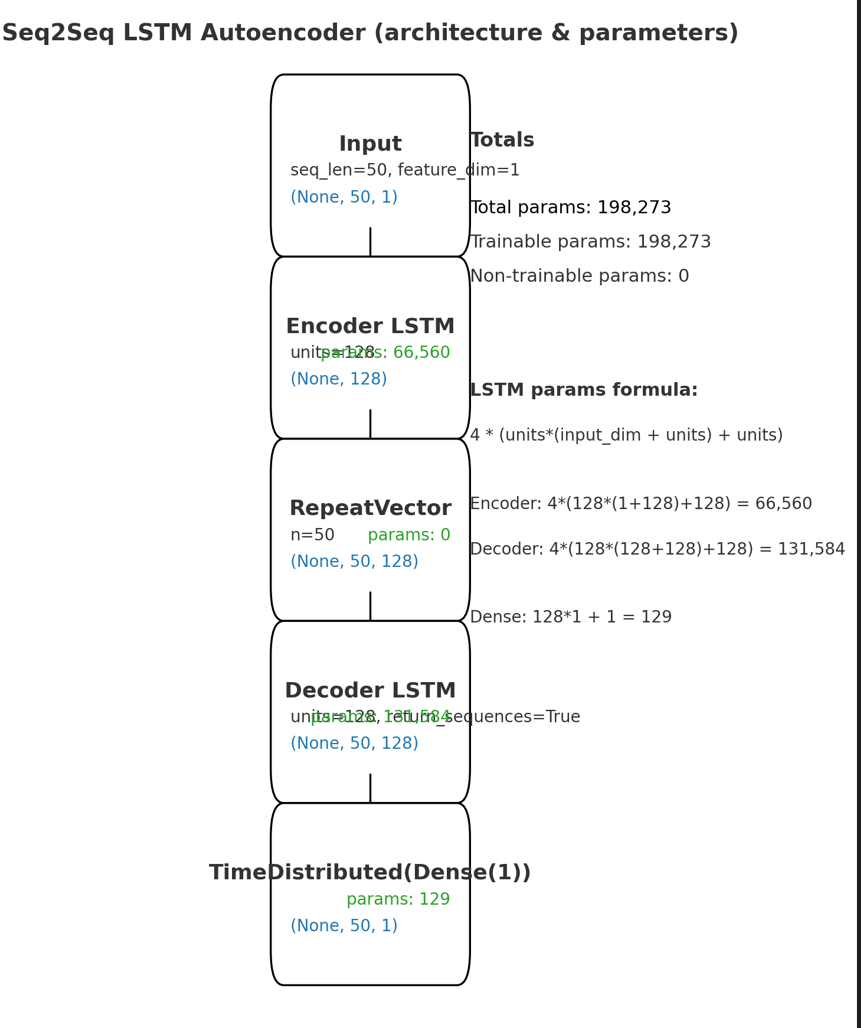

In [5]:
# Performance and evaluate

import numpy as np

def compute_snr(clean, signal):
    # Avoid zero-division
    noise = clean - signal
    # Add a small epsilon to the denominator to avoid division by zero if noise variance is 0
    return 10*np.log10(np.var(clean) / (np.var(noise) + 1e-8))

# Select a sample from the validation set for demonstration
sample_index = 0
y_noisy = X_val[sample_index]
y_clean = Y_val[sample_index]
y_denoised = model.predict(y_noisy.reshape(1, -1, 1))[0]


snr_noisy = compute_snr(y_clean, y_noisy)
snr_denoised = compute_snr(y_clean, y_denoised)

print(f"SNR of noisy signal: {snr_noisy:.2f} dB")
print(f"SNR of denoised signal: {snr_denoised:.2f} dB")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
SNR of noisy signal: 13.46 dB
SNR of denoised signal: 35.53 dB


In [6]:
def compute_rmspe(y_true, y_pred):
    # Exclude points where true value is zero
    mask = y_true != 0
    return np.sqrt(np.mean(((y_pred[mask] - y_true[mask]) / y_true[mask])**2))

rmspe = compute_rmspe(y_clean, y_denoised)


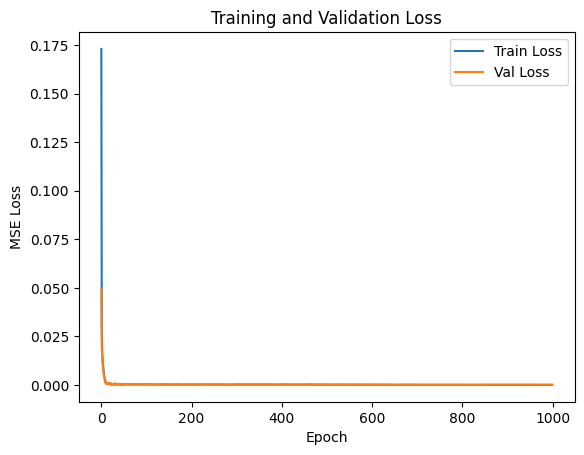

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


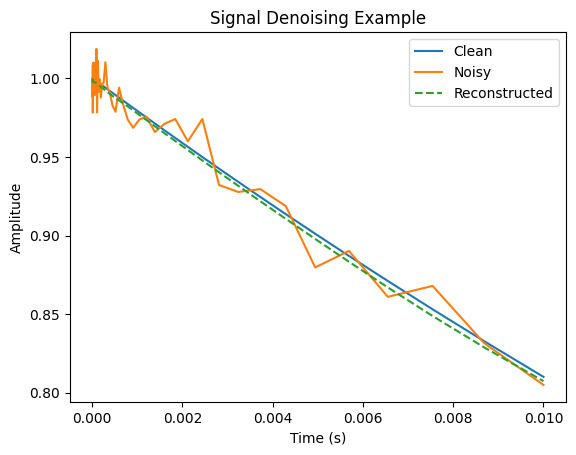

In [7]:
import matplotlib.pyplot as plt

# Example: plot loss curves
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss'); plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Example: compare signals
example_idx = 0
y_clean = Y_val[example_idx,:,0]
y_noisy = X_val[example_idx,:,0]
y_denoised = model.predict(y_noisy.reshape(1,-1,1))[0,:,0]

plt.figure()
plt.plot(t, y_clean, label='Clean')
plt.plot(t, y_noisy, label='Noisy')
plt.plot(t, y_denoised, '--', label='Reconstructed')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude')
plt.legend(); plt.title('Signal Denoising Example')
plt.show()


In [11]:
# Save model import os, json
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import json # Import json library

os.makedirs("artifacts", exist_ok=True)

# 2.1. Сохранить модель (архитектура + веса)
model.save("artifacts/lstm_ae.keras")

# 2.2. Нормировщик (пример с MinMaxScaler)
# допустим, вы обучали на X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 1))
# и перед моделью возвращали форму (batch, timesteps, 1)

# Initialize and fit the scaler
scaler = MinMaxScaler(feature_range=(0,1))
# Reshape X_train for fitting the scaler
X_train_reshaped = X_train.reshape(-1, 1)
scaler.fit(X_train_reshaped)

joblib.dump(scaler, "artifacts/scaler.joblib")

# 2.3. Конфиг проекта
config = {
    "timesteps": int(X_train.shape[1]),
    "features": 1,
    "normalization": "MinMaxScaler(feature_range=(0,1))",
    "time_grid_log10": [float(np.log10(t.min())), float(np.log10(t.max()))],  # если используете общую сетку
    "snr_metric": "10*log10(var(signal)/var(error))",
    "rmspe_metric": "sqrt(mean(((y_pred - y_true)/y_true)^2))",
    "framework": "tensorflow",
    "tf_keras_version": ">=2.14",
    "random_seed": 42
}
with open("artifacts/config.json", "w", encoding="utf-8") as f:
    json.dump(config, f, ensure_ascii=False, indent=2)

In [12]:
import numpy as np
import joblib, json
import tensorflow as tf

# Метрики
def compute_snr(y_true, y_signal):
    noise = y_true - y_signal
    # защита от деления на ноль
    if np.var(noise) == 0:
        return np.inf
    return 10.0 * np.log10(np.var(y_true) / np.var(noise))

def compute_rmspe(y_true, y_pred, eps=1e-12):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = np.abs(y_true) > eps
    if not np.any(mask):
        return np.nan
    return np.sqrt(np.mean(((y_pred[mask] - y_true[mask]) / y_true[mask])**2))

# Загрузка артефактов
model = tf.keras.models.load_model("artifacts/lstm_ae.keras")
scaler = joblib.load("artifacts/scaler.joblib")
with open("artifacts/config.json", "r", encoding="utf-8") as f:
    cfg = json.load(f)

TIMESTEPS = cfg["timesteps"]

def denoise_trace(raw_trace_1d, clean_reference_1d=None):
    """raw_trace_1d: np.ndarray shape (TIMESTEPS,)
       clean_reference_1d: опционально, если есть эталон для подсчёта метрик"""
    x = np.array(raw_trace_1d, dtype=np.float32).reshape(-1, 1)          # (T,1)
    x_scaled = scaler.transform(x)                                       # (T,1)
    x_scaled = x_scaled.reshape(1, TIMESTEPS, 1)                          # (1,T,1)

    y_scaled = model.predict(x_scaled, verbose=0)[0, :, 0]               # (T,)
    # денормализация
    y_denoised = scaler.inverse_transform(y_scaled.reshape(-1,1))[:,0]   # (T,)

    # метрики (если есть чистая трасса)
    metrics = {}
    if clean_reference_1d is not None:
        y_true = np.array(clean_reference_1d).astype(np.float32)
        metrics["SNR_noisy"]    = compute_snr(y_true, raw_trace_1d)
        metrics["SNR_denoised"] = compute_snr(y_true, y_denoised)
        metrics["SNR_gain_dB"]  = metrics["SNR_denoised"] - metrics["SNR_noisy"]
        metrics["RMSPE"]        = float(compute_rmspe(y_true, y_denoised))

    return y_denoised, metrics


In [13]:
# допустим, new_raw — ваш новый зашумлённый сигнал (длины TIMESTEPS)
# а new_clean — эталон (если есть), иначе передайте None
y_rec, m = denoise_trace(new_raw, clean_reference_1d=new_clean)
print(m)  # метрики


NameError: name 'new_raw' is not defined

In [14]:
import os, glob, csv
import numpy as np
import matplotlib.pyplot as plt

os.makedirs("results/plots", exist_ok=True)
rows = [("file","snr_noisy","snr_denoised","snr_gain_db","rmspe")]

def load_vector(path):
    if path.endswith(".npy"):
        v = np.load(path)
    else:
        # .csv: берем первую колонку, игнорируя заголовок
        v = np.loadtxt(path, delimiter=",", ndmin=1)
    return v.squeeze()

for path in glob.glob("inference_input/*.*"):
    try:
        raw = load_vector(path)
        if raw.shape[0] != TIMESTEPS:
            print(f"Skip {path}: wrong length {raw.shape[0]} (need {TIMESTEPS})")
            continue

        # попытка найти эталон с тем же именем в папке reference (необязательно)
        base = os.path.splitext(os.path.basename(path))[0]
        ref_path_npy = f"reference/{base}.npy"
        ref_path_csv = f"reference/{base}.csv"
        ref = None
        if os.path.exists(ref_path_npy):
            ref = load_vector(ref_path_npy)
        elif os.path.exists(ref_path_csv):
            ref = load_vector(ref_path_csv)

        y_rec, metrics = denoise_trace(raw, clean_reference_1d=ref)

        # график до/после
        plt.figure()
        t = np.arange(TIMESTEPS)  # если у вас есть реальная сетка t, подставьте её
        plt.plot(t, raw, label="Noisy", alpha=.7)
        if ref is not None:
            plt.plot(t, ref, label="Clean (ref)", linewidth=2)
        plt.plot(t, y_rec, "--", label="Denoised", linewidth=2)
        plt.xlabel("Time index"); plt.ylabel("Amplitude"); plt.legend()
        plt.title(base)
        plt.tight_layout()
        plt.savefig(f"results/plots/{base}.png", dpi=180)
        plt.close()

        if metrics:
            rows.append((
                base,
                metrics["SNR_noisy"],
                metrics["SNR_denoised"],
                metrics["SNR_gain_dB"],
                metrics["RMSPE"]
            ))
        else:
            rows.append((base, "", "", "", ""))

        # сохраняем восстановленную трассу
        np.save(f"results/{base}_denoised.npy", y_rec)

    except Exception as e:
        print("Error on", path, e)

# CSV со сводкой
with open("results/summary.csv","w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerows(rows)

print("Готово: results/summary.csv и папка results/plots/")


Готово: results/summary.csv и папка results/plots/
